# DACON 뉴스 토픽 분류 AI 경진대회
- 목표: 한국어 📰뉴스 헤드라인을 이용하여, 뉴스의 주제를 분류하는 알고리즘 개발
- https://dacon.io/competitions/official/235747/overview/description
- 평가 metric: Accuracy

In [55]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re

#Tokenizer
from eunjeon import Mecab
from konlpy.tag import Okt
from tokenizers import BertWordPieceTokenizer

#Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
submission = pd.read_csv('sample_submission.csv')
topic_dict = pd.read_csv('topic_dict.csv')

In [5]:
print(train.shape)
print(test.shape)
train.head()

(45654, 3)
(9131, 2)


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [6]:
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## EDA

In [7]:
# 결측치 확인 => 없음
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [8]:
# 중복값 확인 => 없음
print(train['title'].duplicated().sum())
print(test['title'].duplicated().sum())

0
0


In [9]:
train['title_len'] = [len(i) for i in train['title']]
test['title_len'] = [len(i) for i in test['title']]

topic_len_eda = train.groupby('topic_idx')['title_len'].describe()
topic_len_eda.index = topic_dict.topic
topic_len_eda

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
IT과학,4824.0,27.511816,4.775259,8.0,25.0,28.0,31.0,44.0
경제,6222.0,27.325940,4.445584,6.0,25.0,28.0,30.0,43.0
사회,7362.0,26.458571,5.461377,5.0,24.0,27.0,30.0,44.0
생활문화,5933.0,24.721389,6.128354,5.0,22.0,26.0,29.0,44.0
세계,7629.0,28.960939,3.650114,8.0,27.0,29.0,31.0,41.0
스포츠,6933.0,28.785951,3.561802,8.0,27.0,29.0,31.0,42.0
정치,6751.0,27.112132,5.172121,4.0,25.0,28.0,31.0,41.0


- topic별 문서 수, 문장 길이 차이 많이 나지 않음
    ⇒ class 불균형으로 인한 문제 일어날 가능성 적음

In [10]:
train[train['title_len']==train['title_len'].max()]

,index,title,topic_idx,title_len
11037,11037,그래픽 네이처 세계 연구기관 2017년 평가 발표…서울대 국내 1위·세계 70위,2,44
19126,19126,주말 N 여행 영남권 겨울바다 낭만…부산 갈맷길 1∼3코스 89.2㎞ 절경 즐비,3,44
21362,21362,MWC 2018 갤S9 64GB 출고가 95만7천원…자급제 포함 28일 예약판매,0,44
40153,40153,KIST 오우택 박사 심장 혈압 감지센서 발견…고혈압 이해·치료제개발 기여 기대,0,44
43361,43361,IBS·프랑스 연구팀 유리 입자끼리 임계점에서 뭉치는 케이지 형성 과정 첫 규명,0,44


- max_len 길지 않음

In [11]:
print(train['title_len'].mean(), test['title_len'].mean())

27.330551539843167 27.2603219800679


- train 데이터와 test 데이터의 text 길이 차이 거의 안남
    ⇒ overfitting 가능성 낮음

In [19]:
x0 = train[train['topic_idx']==0].title
x1 = train[train['topic_idx']==1].title
x2 = train[train['topic_idx']==2].title
x3 = train[train['topic_idx']==3].title
x4 = train[train['topic_idx']==4].title
x5 = train[train['topic_idx']==5].title
x6 = train[train['topic_idx']==6].title

In [36]:
def label_token_tfidf(label_data, label, n_token=10):
    
    tfidf = TfidfVectorizer(max_features=500, lowercase=False)
    X_dtm = tfidf.fit_transform(label_data)

    terms = tfidf.get_feature_names()
    sums = X_dtm.sum(axis=0) # 특정 단어의 tf-idf score를 모든 문서에 대해 sum

    data = []
    for col, term in enumerate(terms):
        data.append((term, int(sums[0,col])))
    
    ranking = pd.DataFrame(data, columns=[label,'<=rank'])
    top_df = ranking.sort_values('<=rank', ascending=False).head(n_token)
    top_df.reset_index(inplace=True, drop=True)
    top_df.drop(columns=['<=rank'], inplace=True)
    
    return top_df

In [37]:
x0_term = label_token_tfidf(x0, topic_dict.topic[0], n_token=10)
x1_term = label_token_tfidf(x1, topic_dict.topic[1], n_token=10)
x2_term = label_token_tfidf(x2, topic_dict.topic[2], n_token=10)
x3_term = label_token_tfidf(x3, topic_dict.topic[3], n_token=10)
x4_term = label_token_tfidf(x4, topic_dict.topic[4], n_token=10)
x5_term = label_token_tfidf(x5, topic_dict.topic[5], n_token=10)
x6_term = label_token_tfidf(x6, topic_dict.topic[6], n_token=10)

In [38]:
pd.concat([x0_term, x1_term, x2_term, x3_term, x4_term, x5_term, x6_term], axis=1)

,IT과학,경제,사회,생활문화,세계,스포츠,정치
0,출시,코스피,게시판,신간,트럼프,감독,朴대통령
1,개발,출시,코로나19,여행,이란,월드컵,대통령
2,5G,작년,지원,주말,터키,류현진,김정은
3,KT,영업익,KBS,출간,사망,아시안게임,북한
4,AI,특징주,사장,개막,중국,MLB,한국당
5,네이버,그래픽,개최,공연,대통령,시즌,문대통령
6,삼성,게시판,수능,한국,시리아,프로농구,정부
7,SKT,증가,선정,개최,미국,손흥민,여야
8,LG,1분기,모집,게시판,홍콩,꺾고,더민주
9,게시판,규모,MBC,서울,EU,SK,국회


## 전처리

**<전처리에서 고려할 것들>**

**1. Tokenizer 선택**
1. 형태소분석 기반: 사전 형태로 정의된 오픈소스 패키지 사용. 자주 쓰이는 단어가 많은 경우 좋은 결과
   - Mecab
   - Okt
2. BPE 기반: corpus(문서 전체 텍스트)를 주어주면 빈도를 계산하여 vocab 생성 후 tokenize. 모르는 단어가 많은 경우 좋은 결과
   - WordPiece


**2. (Tokenizer를 기반으로) Vocabulary 생성**
- vocab_size (최대 크기 지정, 여기 없는 단어는 모두 \<uknown> token으로 동일하게 처리됨)
- min_freq (최소 n번 등장해야 vocab에 들어가도록)
- \* vocab_size 미리 지정 안하고 min_freq=1이면, 데이터에서 나온 모든 단어가 vocab에 들어감


**3. Encoding 방법 선택**
1. CountVectorizer: 각 문장에서 해당 token이 몇 번 등장했는지 count함
2. TfidfVectorizer: 각 문장에서 해당 token의 tfidf 점수를 계산
3. 정수인코딩: sequential modeling에서 사용 (문장 내 token 순서 고려)

**가벼운 모델인 LogisticRegression으로 여러 전처리 방법의 성능을 비교. train data의 30%를 test로 사용함**

In [49]:
def identity_tokenizer(text):
        return text

In [50]:
def test_accuracy(train, tokenizer, encoding, random_state=42):
    
    if type(tokenizer)==BertWordPieceTokenizer:
        text = [tokenizer.encode(t).tokens for t in train['title']]
    else:
        text = [tokenizer.morphs(t) for t in train['title']]

    if encoding=='tfidf':
        vect = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
        matrix_train = vect.fit_transform(text)
    elif encoding=='count':
        vect = CountVectorizer(tokenizer=identity_tokenizer, lowercase=False)
        matrix_train = vect.fit_transform(text)
    
    print('Vocab size:', matrix_train.shape[1])
    X_train, X_test, y_train, y_test = train_test_split(matrix_train, train['topic_idx'], 
                                                        test_size=0.3, random_state=random_state, stratify=train['topic_idx'])
    lr = LogisticRegression(random_state=42,solver='lbfgs',max_iter=500)
    lr.fit(X_train,y_train)
    pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    print('정확도', accuracy)

### (예시1) BertWordPieceTokenizer / vocab_size=10000 / min_freq=2 / tfidf

In [52]:
tokenizer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)

tokenizer.train(['text.txt'], 
               vocab_size=10000, 
               min_frequency=2,
               show_progress=True)
tokenizer

Tokenizer(vocabulary_size=10000, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

In [53]:
## 생성된 vocabulary
tokenizer.get_vocab()

{'비트': 8208,
 '의문': 9619,
 '내전': 4149,
 '가자지구': 5834,
 '##정당': 4642,
 '공룡': 9104,
 '서훈': 8215,
 '유력': 3168,
 '편집': 4520,
 '중순': 9234,
 '물밑': 9999,
 '광주전남': 9797,
 '오': 643,
 '둑': 280,
 '시드': 9186,
 '영': 639,
 '위클리': 3711,
 '##과학기술': 7201,
 '희생자': 5501,
 '임종석': 5952,
 '도움': 4191,
 '##포럼': 3559,
 '오리온': 4773,
 '##주가': 3904,
 '사내': 7703,
 '반부패': 8196,
 '##하지만': 8322,
 '##K': 1005,
 '의미': 5281,
 '고용': 2518,
 '기가': 5090,
 '출입': 5289,
 '유연': 7491,
 '3연승': 3291,
 '나누는': 4389,
 '갤럭': 2056,
 '##렉시트': 2493,
 '분수령': 8823,
 '연기': 2463,
 '##니아': 3022,
 '##픽': 1639,
 '공습': 3597,
 '제1회': 9431,
 '##윤리': 8985,
 '동양': 9124,
 '정식': 5378,
 '사회복지': 9810,
 '첨단': 6753,
 '웨어러블': 7874,
 '##수사': 5308,
 '송금': 9595,
 '##부': 1259,
 '부적절': 8128,
 '곽': 137,
 '밝히는': 9149,
 '국제사회': 5494,
 '각국': 8448,
 '아이': 2068,
 '##군': 1454,
 '##또': 1783,
 '인삼공사': 3651,
 '트럼프와': 6063,
 '시사': 4569,
 '비즈': 6898,
 '러브': 7677,
 '한투증권': 4838,
 '##배정': 7541,
 '##결산': 9333,
 '빅데이터': 4735,
 '8개': 5508,
 'SF': 9507,
 '##차량': 7555,
 'B': 18,


In [63]:
## tokenized 결과 예시
print(tokenizer.encode(test['title'][0]).tokens)

['유튜브', '내달', '2일', '##까지', '크', '##리에', '##이터', '지원', '공간', '운영']

In [71]:
test_accuracy(train, tokenizer, encoding='tfidf')

Vocab size: 9701
정확도 0.8423012338468278


### (예시2) Mecab / vocab_size=있는만큼 / tfidf

In [47]:
from konlpy.tag import Okt, Komoran, Kkma
text = test['title'][3]
text = test['title'][4]

mecab = Mecab()
print('Mecab:', mecab.morphs(text))
okt = Okt()
print('Okt:', okt.morphs(text))
t = Komoran()
print('Komoran:',t.morphs(text))
t = Kkma()
print('Kkma:',t.morphs(text))

Mecab: ['회색', '인간', '작가', '김동식', '양심', '고백', '등', '새', '소설', '집', '2', '권', '출간']
Okt: ['회색', '인간', '작가', '김', '동식', '양심', '고백', '등', '새', '소설', '집', '2', '권', '출', '간']
Komoran: ['회색', '인간', '작가', '김', '동', '식', '양심', '고백', '등', '새', '소설집', '2', '권', '출간']
Kkma: ['회색', '인간', '작가', '김', '동', '식', '양심', '고백', '등', '새', '소설집', '2', '권', '출간']


In [43]:
test['title']

0            유튜브 내달 2일까지 크리에이터 지원 공간 운영
1               어버이날 맑다가 흐려져…남부지방 옅은 황사
2           내년부터 국가RD 평가 때 논문건수는 반영 않는다
3       김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4        회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
                     ...               
9126       인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127      노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128       40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129      게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계
9130    유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구
Name: title, Length: 9131, dtype: object

In [56]:
## tokenized 결과 예시
mecab = Mecab()
mecab.morphs(test['title'][0])

['유튜브', '내달', '2', '일', '까지', '크리에이터', '지원', '공간', '운영']

In [24]:
test_accuracy(train, tokenizer=mecab, encoding='tfidf')

Vocab size: 30459
정확도 0.8477038767613346


In [56]:
train['title'] = train['title'].apply(lambda x : re.sub(r"[0-9]+", " ", x)) 
train['title'] = train['title'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

test_accuracy(train, tokenizer=mecab, encoding='tfidf')

Vocab size: 29550
정확도 0.8482879462656056


### (예시3) Okt / vocab_size=있는만큼 / count

In [77]:
## tokenized 결과 예시
okt = Okt()
okt.morphs(test['title'][0])

['유튜브', '내달', '2일', '까지', '크리에이터', '지원', '공간', '운영']

In [27]:
test_accuracy(train, tokenizer=Okt(), encoding='count')

Vocab size: 36110
정확도 0.8419361904066583


### 전체 비교

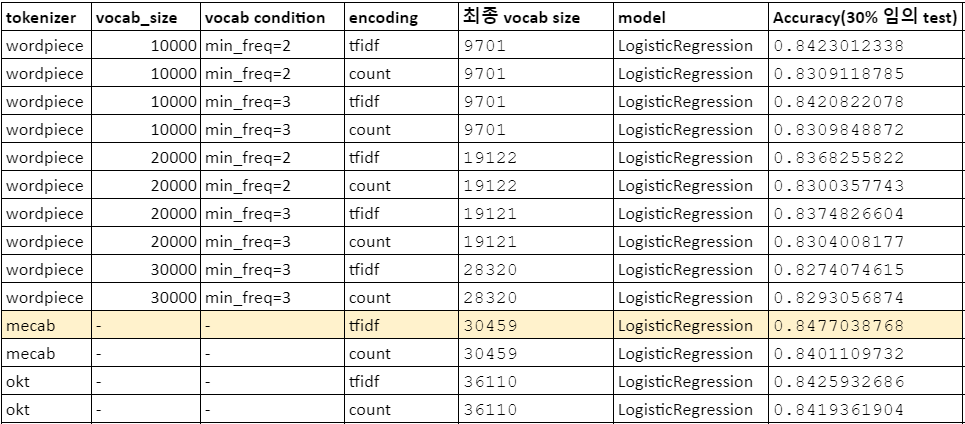

✔️ vocab size가 작아도 성능이 좋을 수 있음

✔️ Tokenizer는 mecab으로 사용

✔️ Encoding은 count보다는 tfidf를 사용하는 것이 성능이 더 좋음

✔️ LogisticRegression 모델로 성능 확인했을 때, tokenizer, vocabulary size, encoding방법 등의 전처리로 인한 성능 차이 크지는 않음

## 모델링

### ML 기반

위의 결과를 바탕으로 Tokenizer는 mecab, Encoding은 tf-idf를 사용하여 대표적인 7가지 회귀 모델의 성능을 기존 train의 30%인 validation set의 정확도로 비교함. 

(대회에서 하루 제출 횟수의 제한이 있기 때문에 validation set을 이용하여 정확도가 높은 모델을 추리는 과정을 진행하였습니다)

(\* random_state=42로 통일)

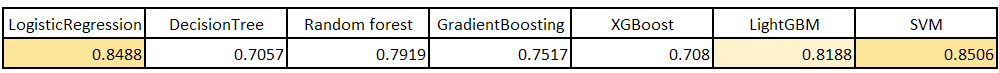

가장 성능이 좋은 LogistiRegression, LightGBM, SVM에 대하여 전체 train set에 대해 모델링하고 DACON에 결과 제출하여 정확도 측정



In [10]:
def identity_tokenizer(text):
        return text

In [ ]:
tokenizer = Mecab()
train_text = [tokenizer.morphs(t) for t in train['title']]
test_text = [tokenizer.morphs(t) for t in test['title']]

vect = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_df)
vect = vect.fit(train_text) # train + test를 fit시켰을 때보다 train만 fit시켰을 때의 성능이 더 좋았음 (lr, lgbm)
matrix_train = vect.transform(train_text)
matrix_test = vect.transform(test_text)
print('Vocab size:', matrix_train.shape[1])

#### LogisticRegression

In [78]:
lr = LogisticRegression(random_state = 42)
lr.fit(matrix_train,train['topic_idx'])
pred = lr.predict(matrix_test)

제출 점수: 0.82344

#### LGBM

In [ ]:
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(matrix_train,train['topic_idx'])
pred = lgbm.predict(matrix_test)

제출 점수: 0.79079

#### SVM

In [12]:
svm = SVC(random_state = 42)
svm.fit(matrix_train,train['topic_idx'])
pred = svm.predict(matrix_test)

제출 점수: 0.82322

**LogisticRegression**의 성능이 가장 좋음. 하지만 현재 리더보드 45위로 낮은 순위. 하이퍼파라미터 튜닝로 드라마틱한 성능 향상 기대하기 어려울 것으로 예상.

### DL 기반

현재 DL 기반의 Sequential 모델인 XLNet, BERT(RoBERT) 등이 text classification 분야에서 SOTA(State-of-the-art)를 달성하고 있기 때문에 Sequential DL모델 사용

#### BERT

Tokenizer는 mecab, Encoding은 sequential한 모델이므로 sequence를 고려한 정수인코딩 사용

Huggingface의 bert-base-multilingual-cased 모델 사용

https://colab.research.google.com/drive/1Z-6kYbnxGxvoio9sBSzsQfuQUuPYF-LX?authuser=2#scrollTo=_gM7-wMvcCe5

제출 점수: (학습 중)